In [1]:
import numpy as np
import jax
import jax.numpy as jnp

import optax
import corner
import matplotlib.pyplot as plt

from functools import partial
import jimgw

import distrax
import haiku as hk     #
from typing import Any, Iterator, Mapping, Optional, Sequence, Tuple   #

from vi_routines import make_flow_model

Array = jnp.ndarray
PRNGKey = Array
OptState = Any

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


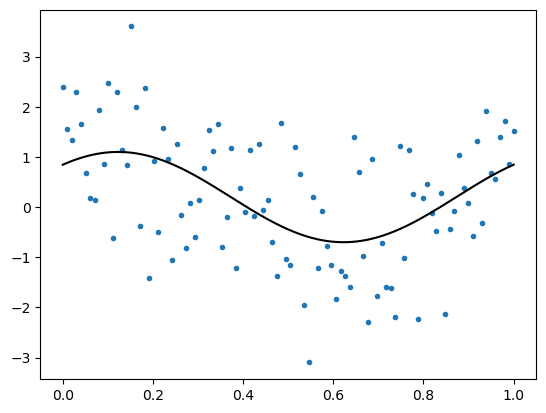

Array(-58.9116, dtype=float32)

In [2]:
def model_sine(x, a, b, c):        #data model with parameters theta=(a,b,c)
    return a*jnp.sin(2*np.pi*x+b)+c           #sine with frequency 1

def simulate_data(model, theta, sigma_noise, n_data_points):
    x_vec = jnp.linspace(0, 1, n_data_points)
    return model(x_vec, *theta) + np.random.normal(0, sigma_noise, n_data_points)

theta = [0.9, 0.8, 0.2]

def log_L(theta, data, sigma_noise, n_data_points):
    x_vec = np.linspace(0, 1, n_data_points)
    model=model_sine(x_vec, *theta)
    return -1/(2*sigma_noise**2) * np.sum((data-model)**2)

x_vec = np.linspace(0, 1, 100)
x_vec_2 = np.linspace(0, 1, 1000)
data = simulate_data(model_sine, theta, 1, 100)
theory = model_sine(x_vec_2, *theta) 
plt.plot(x_vec, data, '.')  
plt.plot(x_vec_2, theory, '-k')    
plt.show()

log_L(theta, data, 1, 100)

In [3]:
log_L([0.9,0.8,0.2], data, 1., 100)

Array(-58.9116, dtype=float32)

In [4]:
#@jax.jit

# likelihood function
class LogL(object):
    
    def __init__(self, true_gw_params = dict(A=0.9,B=0.8,C=0.2), sigma_noise = 1., n_data_points=1000):
        
        self.true_gw_params = true_gw_params
        self.sigma_noise = sigma_noise
        self.x_vec = np.linspace(0, 1, n_data_points)
        self.data = simulate_data(model_sine, [true_gw_params['A'],true_gw_params['B'], true_gw_params['C']], sigma_noise, n_data_points)

        self.bounds = dict(          #not used anywhere 
            A = [0.,2.],
            B = [-jnp.pi, jnp.pi],
            C = [-1., 1.],
        )
    
    def __call__(self, gw_params):
        model_signal = model_sine(self.x_vec, gw_params['A'], gw_params['B'], gw_params['C'])
        residuals = jnp.array(self.data-model_signal)
        
        return -1/(2*self.sigma_noise**2) * jnp.sum(residuals**2)
    
    @property
    def gw_params(self):
        gw_params = ['A','B','C']
        return gw_params

    def array_to_phys(self, x: Array) -> dict:           #transformation from the domain of the flow to 
        p = dict()
        p['A']=x[:,0]+1  #0 to 2                       
        p['B']=x[:,1]*jnp.pi   #-pi to pi
        p['C']=x[:,2]      #-1 to 1

        return p

In [5]:
#Neural network setup

@hk.without_apply_rng
@hk.transform
def sample_and_log_prob(prng_key: PRNGKey, n: int) -> Tuple[Any, Array]:

    model = make_flow_model(                          #this is the flow distribution (a distrax object)
        event_shape=(n_params,),
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins
    )
    return model.sample_and_log_prob(seed=prng_key, sample_shape=(n,))
     # returns x (sample from the flow q), and model.log_prob(x) (array of log(q) of th sampled points)


def log_likelihood(x: Array) -> Array:      #transform to parameter space before c
    p = log_l.array_to_phys(x)
    return log_l(p)

def loss_fn(params: hk.Params, prng_key: PRNGKey, n: int) -> Array:       #computes reverse KL-divergence for the sample x_flow between the flow and gw loglikelihood.

    x_flow, log_q = sample_and_log_prob.apply(params, prng_key, n)           #gets sample from the flow and computes log_q for the sampled points.
    log_p = log_likelihood(x_flow)    
                                           #gets gw loglikelihood for the sampled points (after transforming them into physical space..)
    loss = jnp.mean(log_q - log_p)
    return loss

@jax.jit
def update(
    params: hk.Params,
    prng_key: PRNGKey,
    opt_state: OptState,
) -> Tuple[hk.Params, OptState]:
    """Single SGD update step."""
    grads = jax.grad(loss_fn)(params, prng_key, Nsamps)
    updates, new_opt_state = optimiser.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state


log likelihood of true params = -487.01806640625


  0%|          | 0/1000 [00:00<?, ?it/s, loss=1226.58, T=1]

Epoch 0, loss 1226.5758056640625


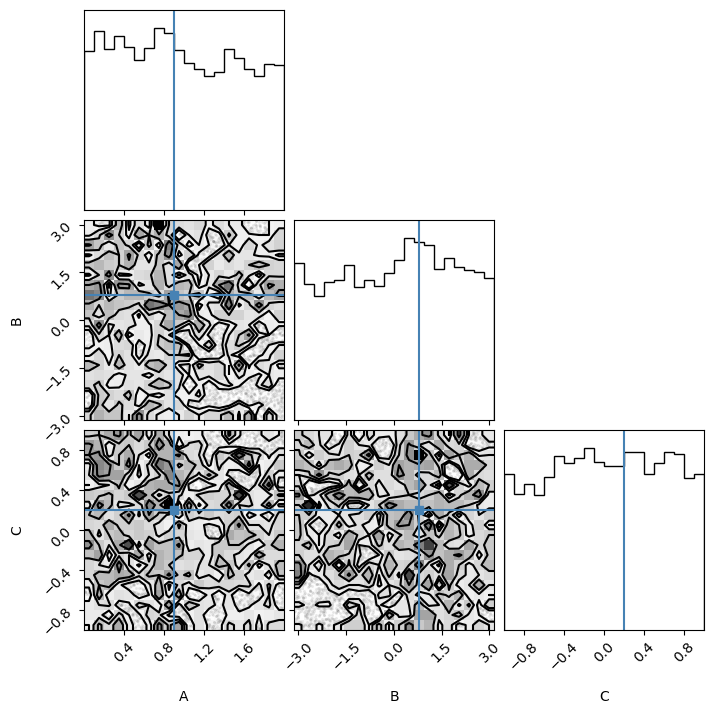

  5%|▌         | 50/1000 [00:26<04:41,  3.38it/s, loss=496.59, T=1]  

Epoch 50, loss 496.5850524902344


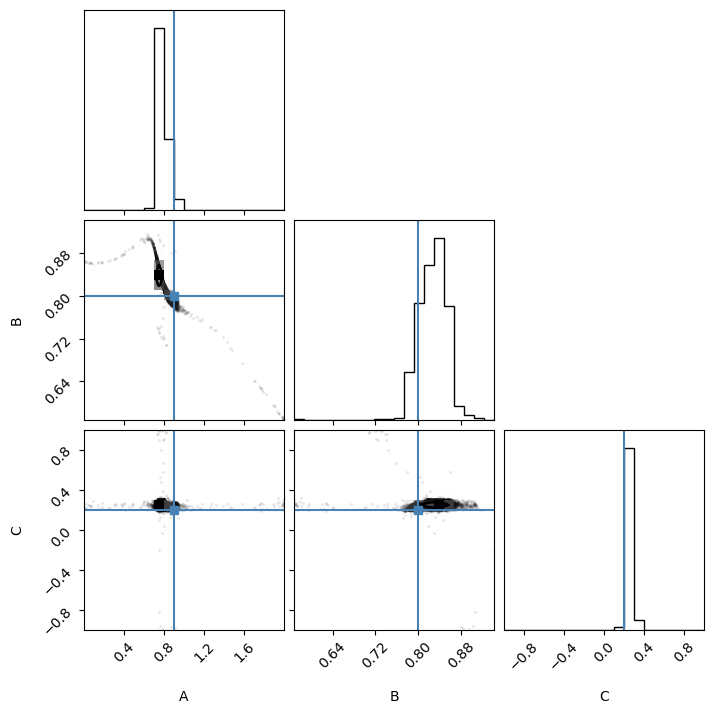

 10%|█         | 100/1000 [00:41<04:22,  3.43it/s, loss=493.84, T=1]

Epoch 100, loss 493.8397521972656


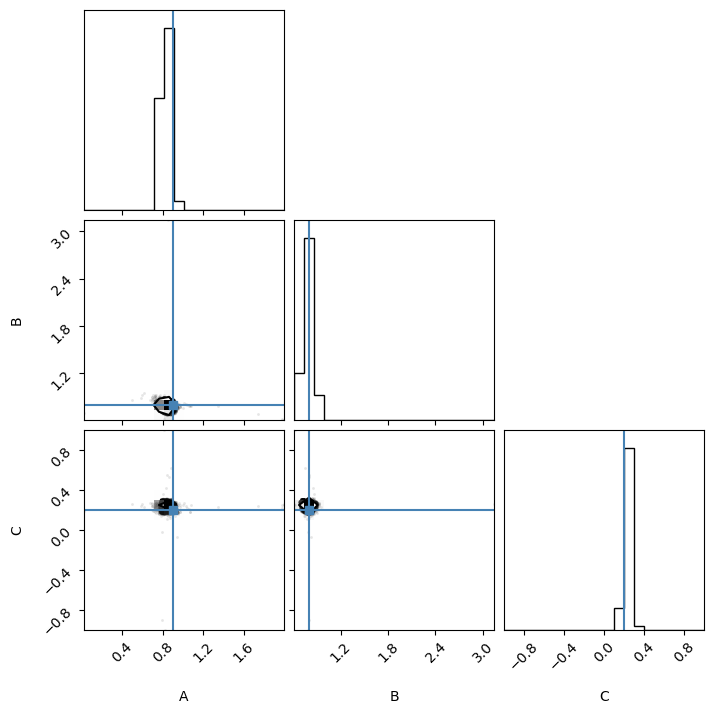

 15%|█▌        | 150/1000 [00:57<04:09,  3.41it/s, loss=491.79, T=1]

Epoch 150, loss 491.7874755859375


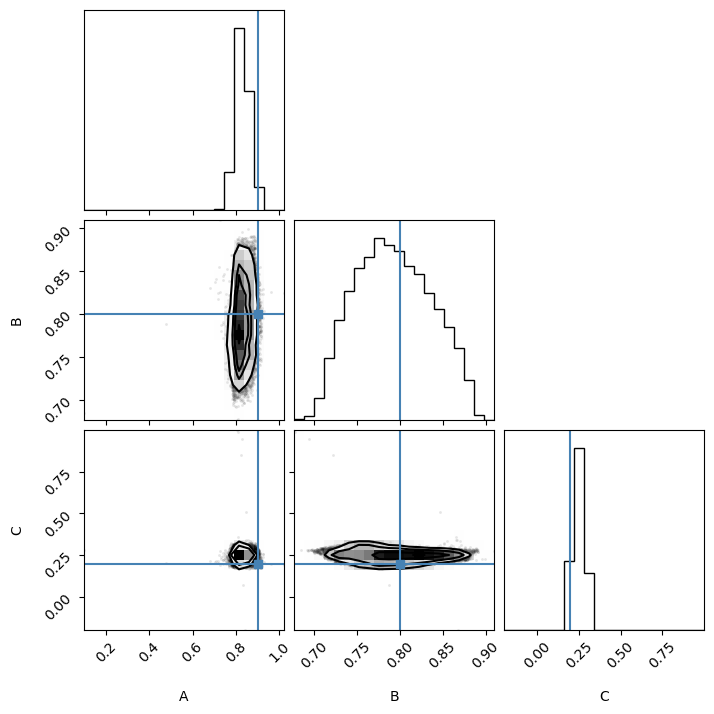

 20%|██        | 200/1000 [01:12<03:58,  3.35it/s, loss=493.91, T=1]

Epoch 200, loss 493.9117431640625


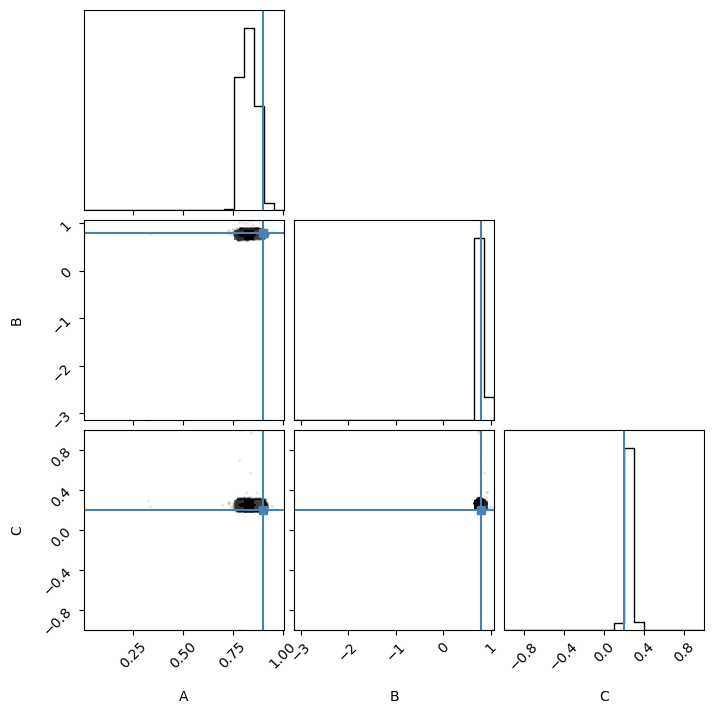

 25%|██▌       | 250/1000 [01:28<03:36,  3.46it/s, loss=496.56, T=1]

Epoch 250, loss 496.5585632324219


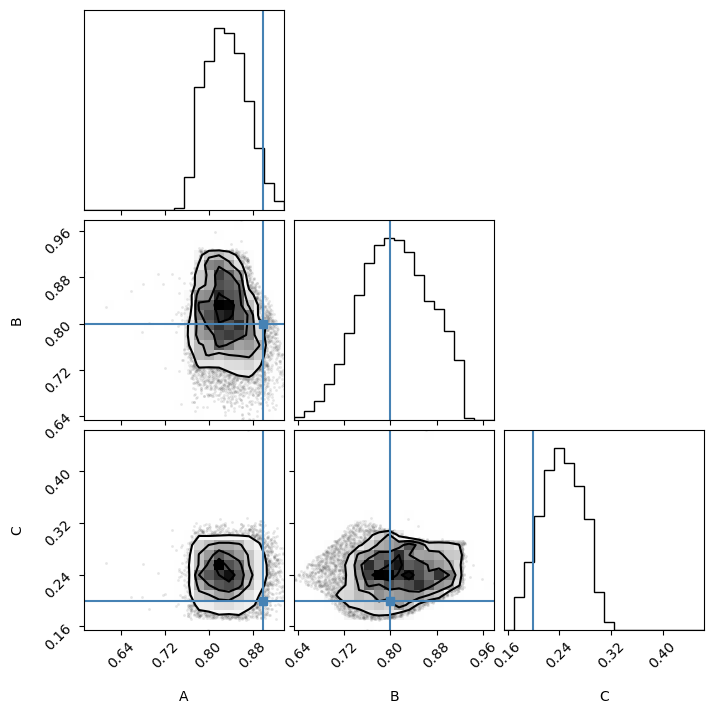

 30%|███       | 300/1000 [01:43<03:21,  3.47it/s, loss=493.13, T=1]

Epoch 300, loss 493.12713623046875


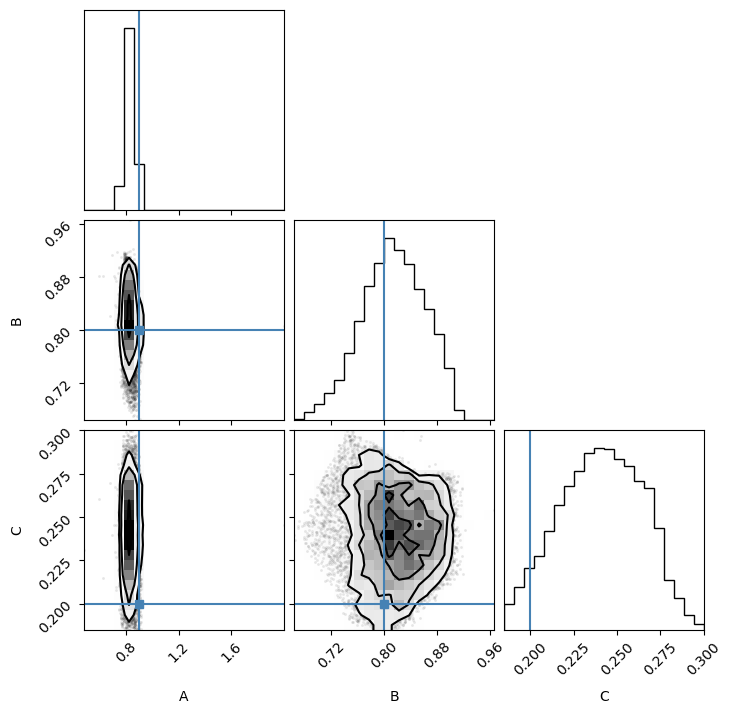

 35%|███▌      | 350/1000 [01:58<03:15,  3.33it/s, loss=497.72, T=1]

Epoch 350, loss 497.71795654296875


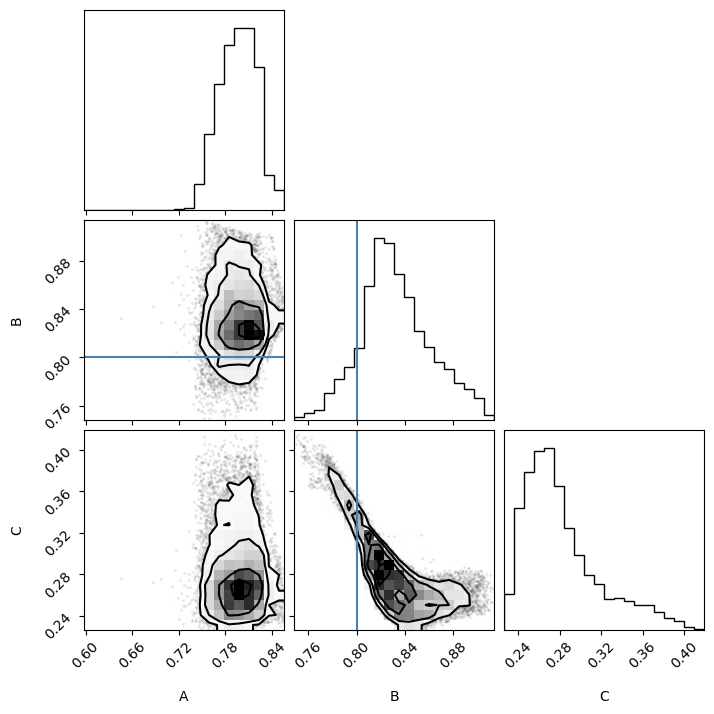

 40%|████      | 400/1000 [02:13<02:52,  3.48it/s, loss=494.12, T=1]

Epoch 400, loss 494.1185302734375


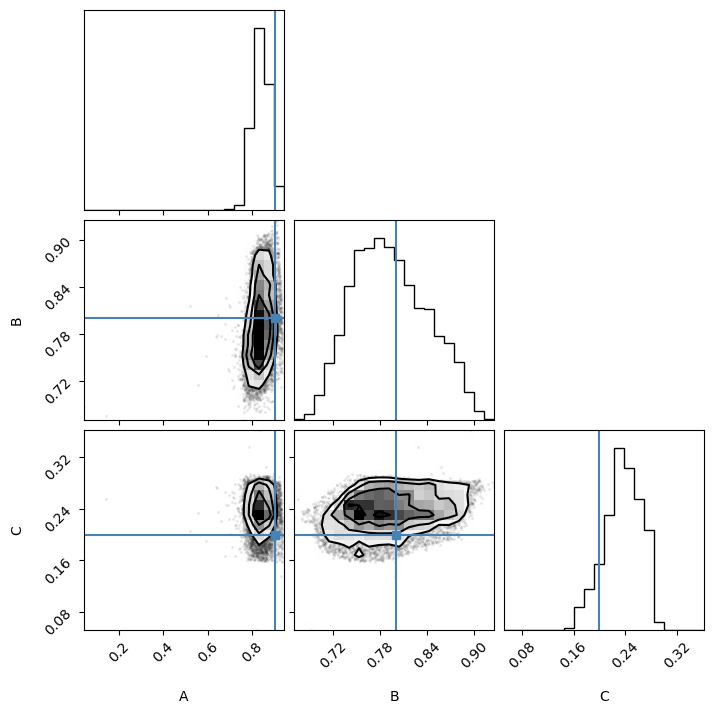

 45%|████▌     | 450/1000 [02:29<02:42,  3.38it/s, loss=489.94, T=1]

Epoch 450, loss 489.9371337890625


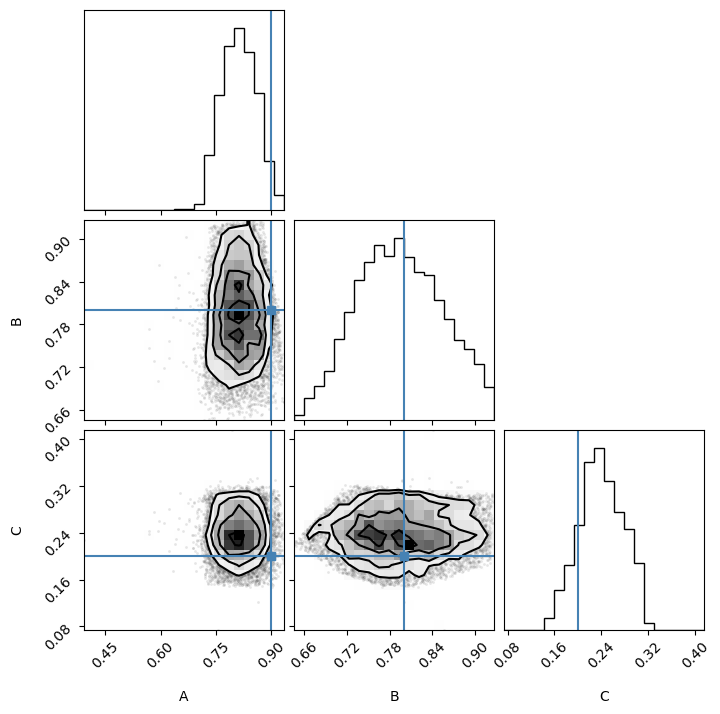

 50%|█████     | 500/1000 [02:44<02:24,  3.46it/s, loss=490.87, T=1]

Epoch 500, loss 490.8701477050781


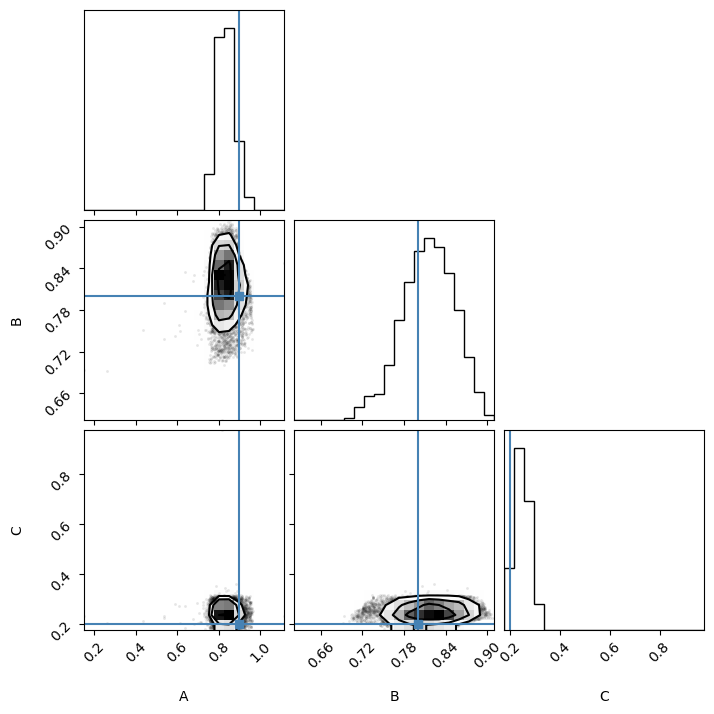

 55%|█████▌    | 550/1000 [02:59<02:12,  3.39it/s, loss=492.79, T=1]

Epoch 550, loss 492.790771484375


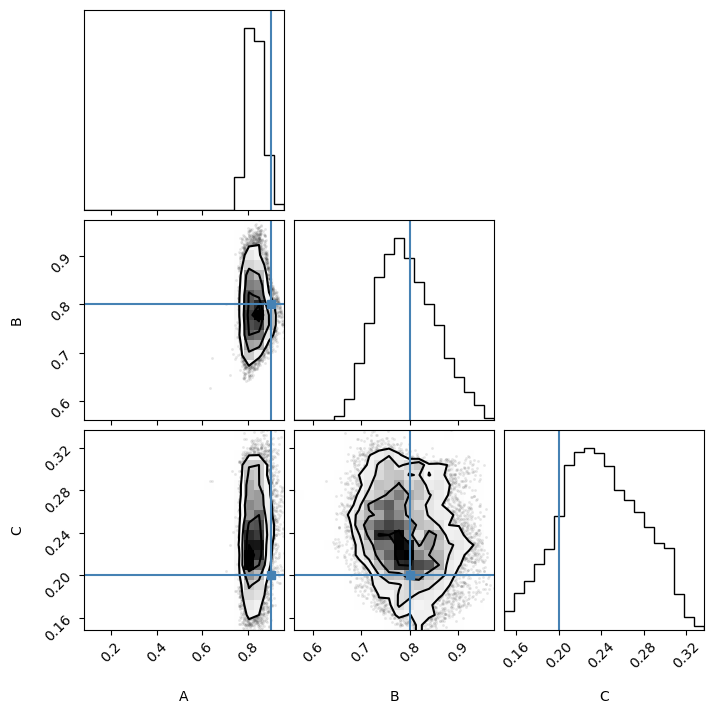

 60%|██████    | 600/1000 [03:15<01:55,  3.46it/s, loss=492.87, T=1]

Epoch 600, loss 492.8704528808594


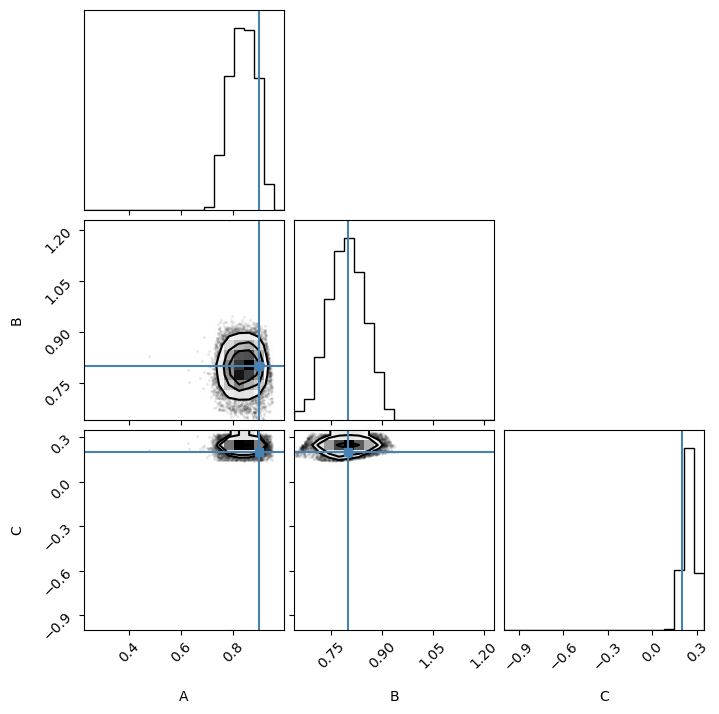

 65%|██████▌   | 650/1000 [03:30<01:42,  3.42it/s, loss=493.36, T=1]

Epoch 650, loss 493.3581237792969


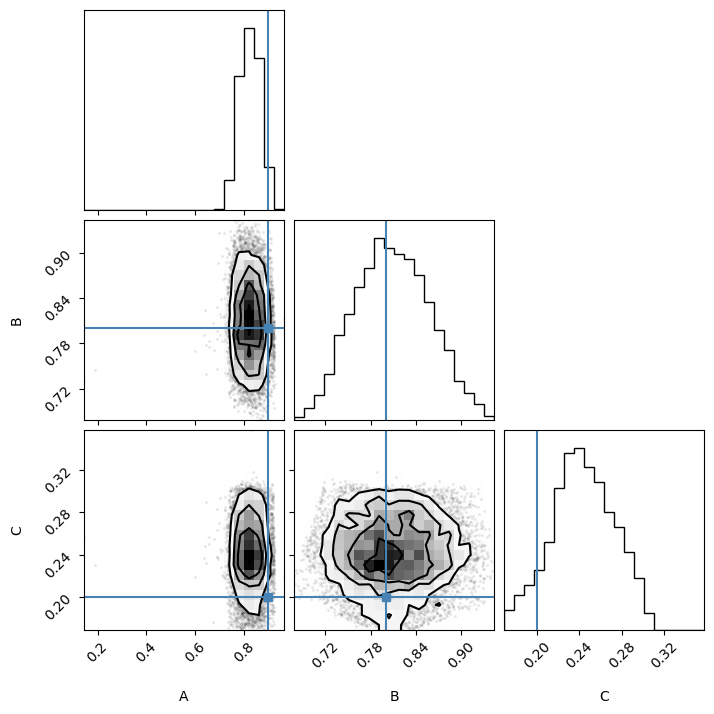

 70%|███████   | 700/1000 [03:45<01:27,  3.44it/s, loss=493.97, T=1]

Epoch 700, loss 493.96832275390625


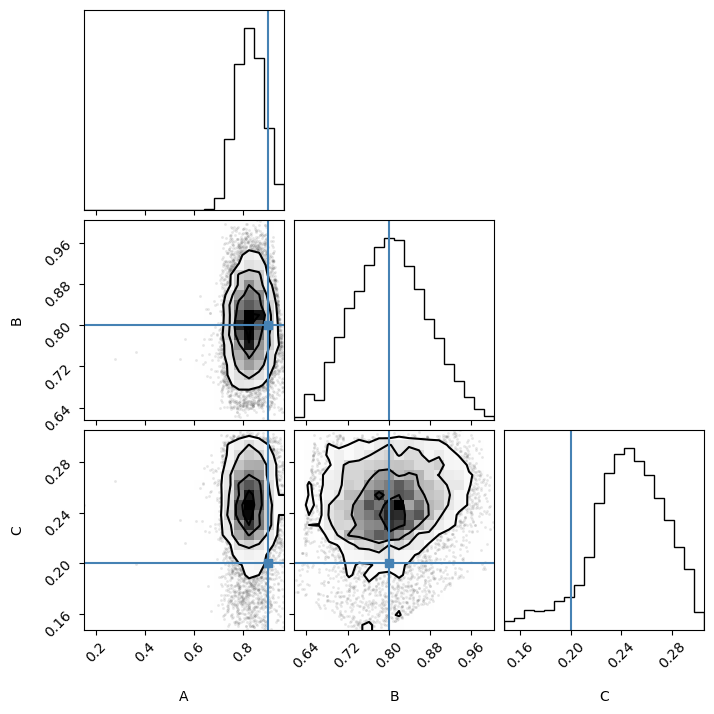

 75%|███████▌  | 750/1000 [04:01<01:12,  3.44it/s, loss=490.62, T=1]

Epoch 750, loss 490.6173400878906


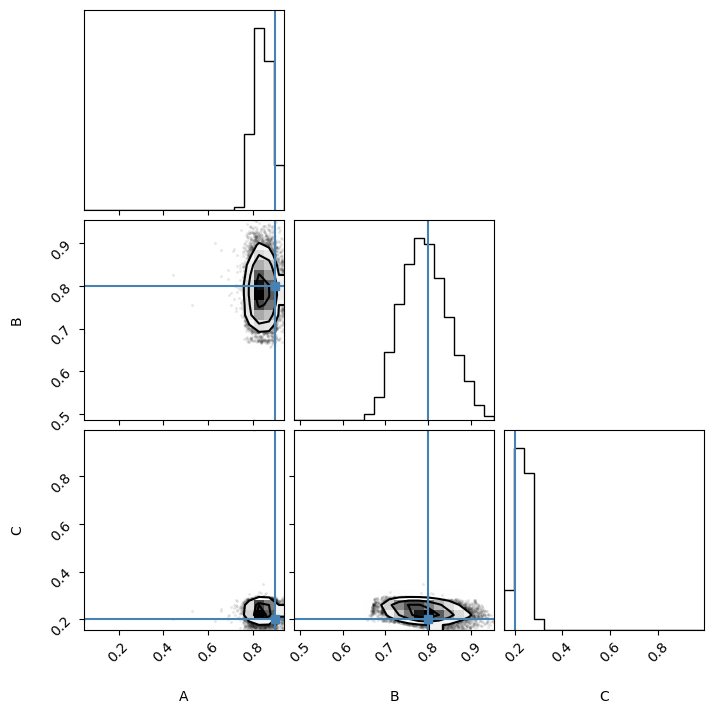

 80%|████████  | 800/1000 [04:16<00:58,  3.44it/s, loss=492.29, T=1]

Epoch 800, loss 492.2915344238281


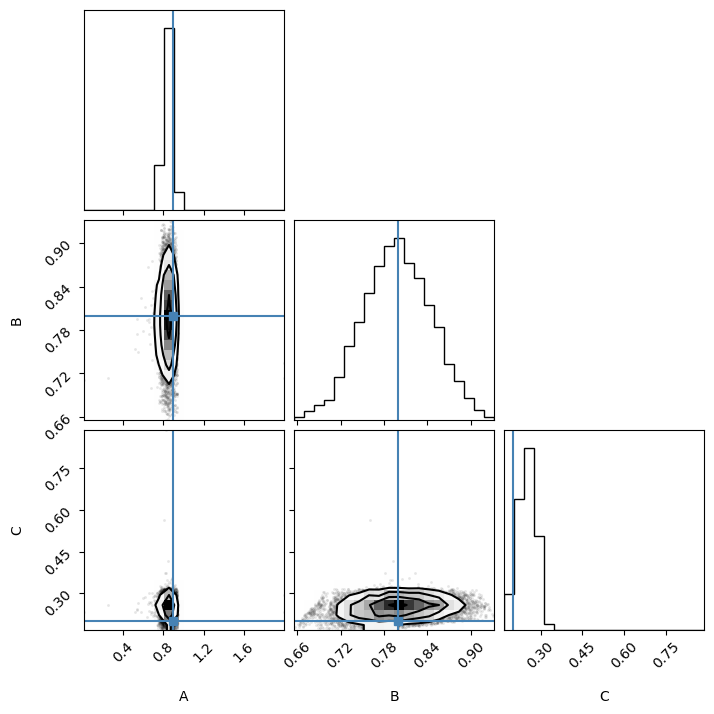

 85%|████████▌ | 850/1000 [04:32<00:44,  3.41it/s, loss=493.18, T=1]

Epoch 850, loss 493.1772766113281


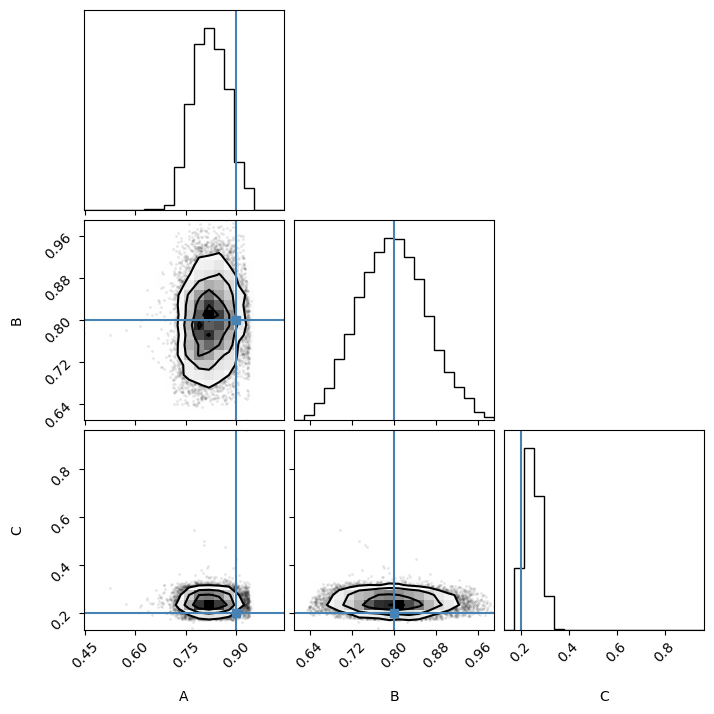

 90%|█████████ | 900/1000 [04:47<00:29,  3.45it/s, loss=494.94, T=1]

Epoch 900, loss 494.941650390625


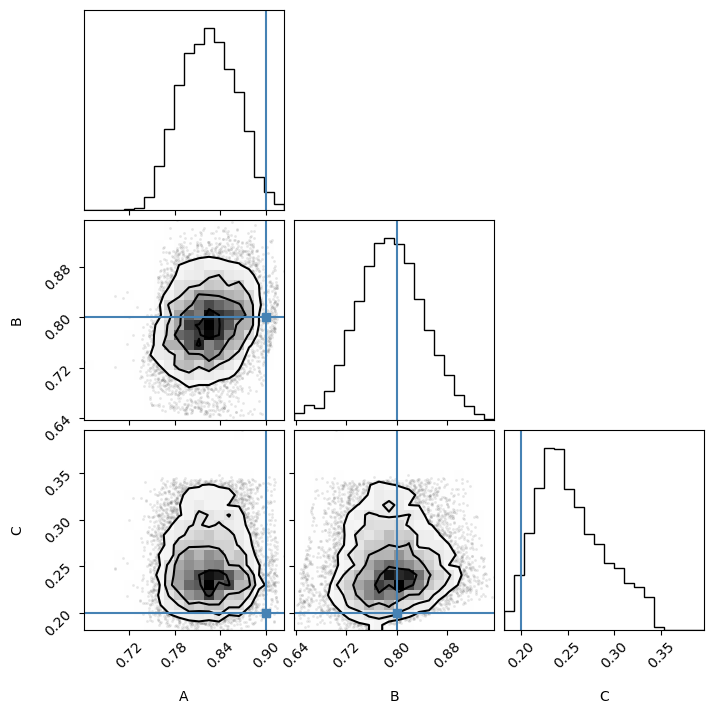

 95%|█████████▌| 950/1000 [05:03<00:14,  3.40it/s, loss=493.06, T=1]

Epoch 950, loss 493.0639343261719


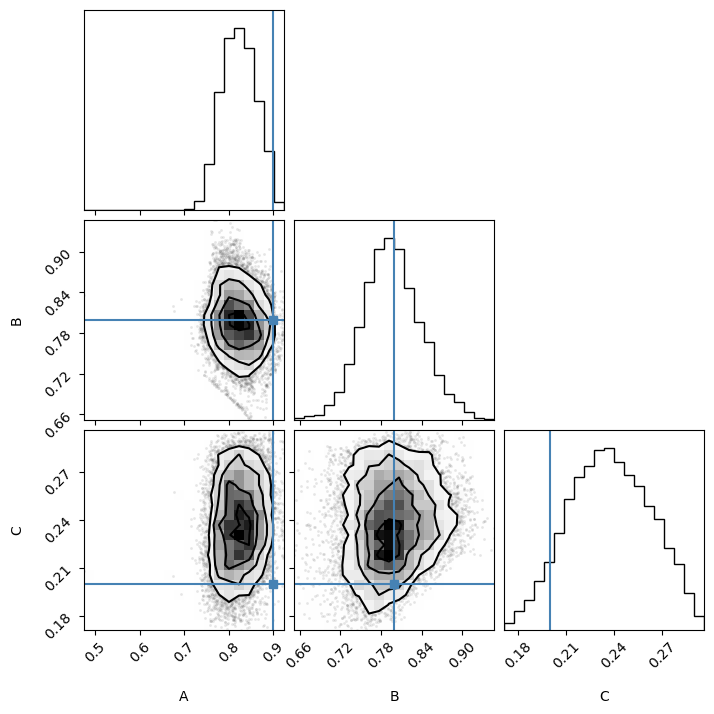

100%|██████████| 1000/1000 [05:18<00:00,  3.14it/s, loss=494.54, T=1]


Done!


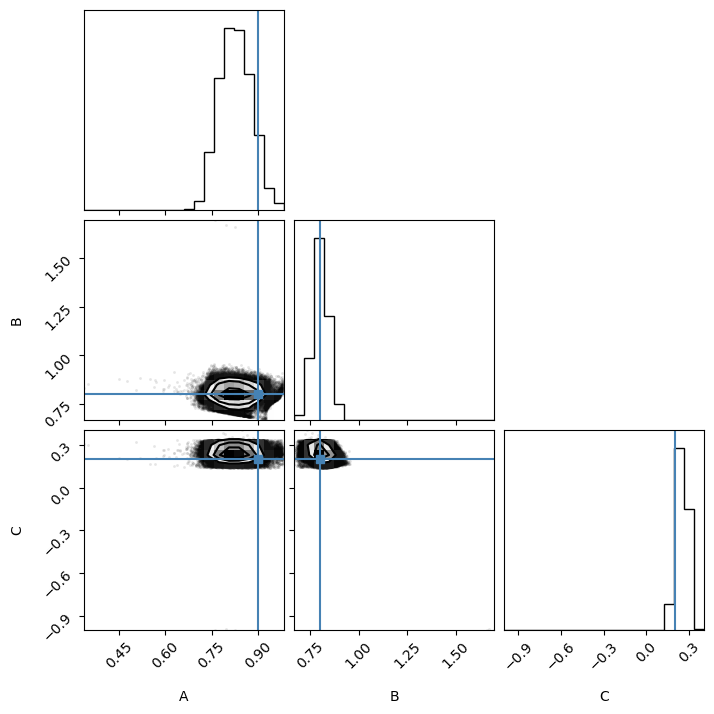

<Figure size 640x480 with 0 Axes>

In [6]:
if __name__ == '__main__':


    log_l = LogL()              

    # Test likelihood
    l = log_l(log_l.true_gw_params)
    print(f'log likelihood of true params = {l}')

    n_params = len(log_l.gw_params)
    flow_num_layers = 4
    hidden_size = 16
    mlp_num_layers = 2
    num_bins = 4


    # perform variational inference
    epochs = 1000
    loss = dict(train=[], val=[])
    Nsamps = 1000

    learning_rate = 0.01
    optimiser = optax.adam(learning_rate)              #stochastic gradient descent 

    prng_seq = hk.PRNGSequence(42)
    key = next(prng_seq)
    params = sample_and_log_prob.init(key, prng_key=key, n=Nsamps)
    opt_state = optimiser.init(params)

    from tqdm import tqdm, trange
   
    ldict = dict(loss = 0, T=1)

    with trange(epochs) as tepochs:
        for epoch in tepochs:
  
            #update NN params (stochastic gradient descent with Adam optimiser)
            prng_key = next(prng_seq)
            loss = loss_fn(params,  prng_key, Nsamps)
            ldict['loss'] = f'{loss:.2f}'
            tepochs.set_postfix(ldict, refresh=True)
            params, opt_state = update(params, prng_key, opt_state)        #take a step in direction of stepest descent (negative gradient)
            
            
            #print results every 50 iterations
            if epoch%50 == 0:
                print(f'Epoch {epoch}, loss {loss}')
                x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 10*Nsamps)
                x_gen = np.array(x_gen, copy=False)
                p_gen = np.vstack(list(log_l.array_to_phys(x_gen).values()))
                truths = [log_l.true_gw_params[n] for n in ['A','B','C']]
                fig = corner.corner(p_gen.T, labels = log_l.gw_params, truths = truths)
                plt.show()

    print("Done!")

    x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 100*Nsamps)

    x_gen = np.array(x_gen, copy=False)
    p_gen = np.vstack(list(log_l.array_to_phys(x_gen).values()))
    truths = [log_l.true_gw_params[n] for n in ['A','B','C']]
    fig = corner.corner(p_gen.T, labels = log_l.gw_params, truths = truths)
    plt.show()
    plt.savefig(f'posterior_${epochs}.png')